<a href="https://colab.research.google.com/github/chaurasia-aditya/CaptchaTheBots/blob/main/resnet50_Hopskip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
sys.path.append("..")

%matplotlib inline

import tensorflow as tf

tf.compat.v1.disable_eager_execution()

import imagenet_stubs
import numpy as np
import tensorflow.keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import tensorflow.keras.backend as k
from keras.models import load_model
from matplotlib import pyplot as plt
from IPython.display import clear_output

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import HopSkipJump
from art.utils import to_categorical

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-0jy0us_7
  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-0jy0us_7
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py) ... done
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-py3-none-any.whl size=794799 sha256=d813e8784febcc0d8958318a417578a42f38925fa993ef9fa580e83dc9408fc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-d8ux23s5/wheels/11/fe/f6/71c84cfe4ee113c44af28273d506ccbd346c66da9db8688fe6
Successfully built imagenet-stubs


In [3]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw

import keras
from keras.datasets import cifar10

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.14.0


In [4]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
(X_train, Y_train) , (X_test, Y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [6]:
# scaling the data

X_train_scaled = X_train/255

X_test_scaled = X_test/255

In [8]:
# To load the model back
model = load_model("resnet50_keras_94.08.h5")

Instructions for updating:
Colocations handled automatically by placer.


# Hopskip

In [9]:
classifier = KerasClassifier(clip_values=(0, 255), model=model)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


HopSkipJump:   0%|          | 0/10000 [00:00<?, ?it/s]

Adversarial image at step 0. L2 error 1761.8686126558703 and class label 3.


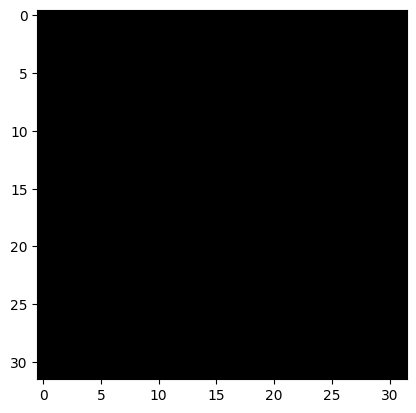

HopSkipJump:   0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [10]:
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = None
for i in range(2):
    x_adv = attack.generate(x=X_test_scaled, x_adv_init=x_adv, resume=True)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error",
          np.linalg.norm(np.reshape(x_adv[0] - X_test_scaled, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0].astype(np.uint))
    plt.show(block=False)

    attack.max_iter = iter_step

In [11]:
print(x_adv.shape)

(10000, 32, 32, 3)


In [13]:
loss, accuracy = model.evaluate(x_adv, Y_test, batch_size=64)
print(accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


0.0931


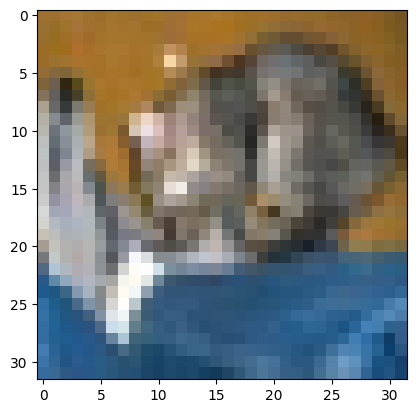

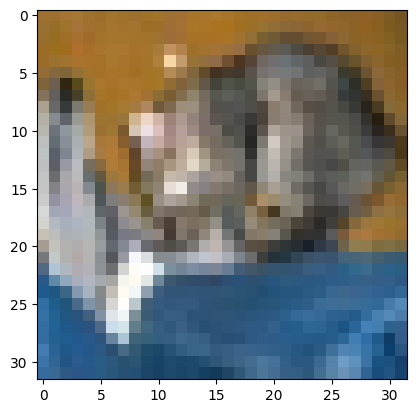

In [16]:
plt.imshow(x_adv[0])
plt.show()
plt.imshow(X_test[0])
plt.show()

In [19]:
print(np.array_equal(x_adv[0], X_test[0]))

False


In [21]:
np.save('Resnet50_hopskip.npy', x_adv)